# Homework 2

In this homework, we are gonna perform some EDA work on our browser history!

Extract & prepare your history dataset using: 
https://github.com/msaricaumbc/DS601/blob/main/Week09/homework/preparation_BrowserHistory.ipynb

DO NOT commit your history dataset!

Watch this: https://www.youtube.com/watch?v=iFTWM7HV2UI

Investigate the data and try to answer the following question.

1. Is this a work computer/personal computer?
1. Is user employed?
1. What are the person's interests?
1. Anything interesting?

What else can we tell about this person?

In [1]:
import sqlite3
from datetime import datetime, timedelta
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
temp_db = "Brave_History_Copy.db"

In [3]:
'''
I use brave browser. So, I had to do some changes to retrieve the domain names and the timestamp.
Looks like the original libarary only supports chrome browser.

'''
conn = sqlite3.connect(temp_db)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the Brave History database:")
for table in tables:
    print(table[0])

Tables in the Brave History database:
meta
downloads
downloads_url_chains
downloads_slices
history_sync_metadata
urls
sqlite_sequence
visits
visit_source
visited_links
keyword_search_terms
segments
segment_usage
content_annotations
context_annotations
clusters
clusters_and_visits
cluster_keywords
cluster_visit_duplicates


In [4]:
# connect to the brave's local database that contains all history
conn = sqlite3.connect(temp_db)
cursor = conn.cursor()

# Query to join urls and visits table
cursor.execute("""
    SELECT urls.url, visits.visit_time
    FROM urls
    JOIN visits ON urls.id = visits.url
    ORDER BY visits.visit_time DESC
""")

# Fetch results
history = cursor.fetchall()

In [5]:
history

[('https://chatgpt.com/c/67a59025-d0e0-8006-9606-77772c1c1c90',
  13383377188501338),
 ('https://chatgpt.com/', 13383377178982731),
 ('https://chat.com/', 13383377178982731),
 ('https://stackoverflow.com/questions/64321899/the-module-browserhistory-doesnt-seem-to-work-and-raises-keyerror',
  13383377158195728),
 ('https://www.google.com/search?q=bh.get_browserhistory&oq=bh.get_browserhistory&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIGCAEQLhhA0gEHMTAxajBqMagCALACAA&sourceid=chrome&ie=UTF-8',
  13383377155637564),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc&ab_channel=L%E1%B4%8F%C9%B4%E1%B4%87%D2%93%C9%AA%C9%B4%C9%AA%E1%B4%9B%CA%8F',
  13383377138040530),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc', 13383377138034982),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc&ab_channel=L%E1%B4%8F%C9%B4%E1%B4%87%D2%93%C9%AA%C9%B4%C9%AA%E1%B4%9B%CA%8F',
  13383377137380855),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc', 13383377137186601),
 ('http://localhost:8888/notebooks/hw2-eda-metadata-analysis_

In [6]:
urls=[]
times = []

# this will just convert the webkit timestamp to the standard UTC timestamp
def convert_time(webkit_timestamp):
    epoch_start = datetime(1601, 1, 1)
    return epoch_start + timedelta(microseconds=webkit_timestamp)


# parse the url to get domain
def get_domain(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc  
    return domain.replace("www.", "") 

# get datetimestamp and domain names and appending them to the corresponding lists
# to create our pandas dataframe
for url, timestamp in history:
    times.append(convert_time(timestamp))
    urls.append(get_domain(url))

df = pd.DataFrame({"date": times, "domain": urls})

In [7]:
df

,date,domain
0,2025-02-07 04:46:28.501338,chatgpt.com
1,2025-02-07 04:46:18.982731,chatgpt.com
2,2025-02-07 04:46:18.982731,chat.com
3,2025-02-07 04:45:58.195728,stackoverflow.com
4,2025-02-07 04:45:55.637564,google.com
...,...,...
77201,2024-12-07 02:34:48.221062,accounts.google.com
77202,2024-12-07 02:34:48.221062,mail.google.com
77203,2024-12-07 02:34:48.221062,gmail.com
77204,2024-12-07 02:34:45.561978,google.com


In [8]:
df["date"].min(), df["date"].max()

(Timestamp('2024-12-07 02:34:44.975372'),
 Timestamp('2025-02-07 04:46:28.501338'))

Looks like I had cleared my browsing history in the early december last year. Still, that should be fine as I have more than 77k records.

In [9]:
df.shape

(77206, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77206 entries, 0 to 77205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    77206 non-null  datetime64[ns]
 1   domain  77206 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.2+ MB


Both columns have not-null values. That's good. Let's extract Year, Month, Day, Hour, and weekday columns from the dataframe

In [11]:
# access year month day hour and day_name from the datetime:stamp
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month
df["Day"] = df["date"].dt.day
df["Hour"] = df["date"].dt.hour
df["Day"] = df["date"].dt.day_name() # gets day name using pandas' built-in calender

In [12]:
# remove ".com" from domain names
df["domain"] = df["domain"].apply(lambda x : x.split(".")[0])

In [13]:
df["domain"].fillna("Unknown", inplace=True)

C:\Users\neupa\AppData\Local\Temp\ipykernel_18192\3592442068.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["domain"].fillna("Unknown", inplace=True)


In [14]:
df.head()

,date,domain,Year,Month,Day,Hour
0,2025-02-07 04:46:28.501338,chatgpt,2025,2,Friday,4
1,2025-02-07 04:46:18.982731,chatgpt,2025,2,Friday,4
2,2025-02-07 04:46:18.982731,chat,2025,2,Friday,4
3,2025-02-07 04:45:58.195728,stackoverflow,2025,2,Friday,4
4,2025-02-07 04:45:55.637564,google,2025,2,Friday,4


# Top 20 Most Visited Pages

In [15]:
# grouping based on domain and the numbre of times the domain was visited, sorting theem and selecting top 20
most_visited_sites_based_on_count = df.groupby("domain")["date"].count().reset_index()
most_visited_sites_based_on_count.rename(columns={"date": "count"}, inplace=True)
most_visited_sites_based_on_count.sort_values("count", inplace=True, ascending=False)
most_visited_sites_based_on_count_top20 = most_visited_sites_based_on_count[: 20] # top 20

In [16]:
most_visited_sites_based_on_count_top20

,domain,count
751,youtube,14316
747,x,8545
306,google,6498
423,mail,5785
365,instagram,5659
566,robinhood,4738
264,facebook,2656
410,linkedin,2587
723,walmart,2004
38,amazon,1978


Text(0.5, 1.0, 'Visualizing the number of times the top 10 sites were visited')

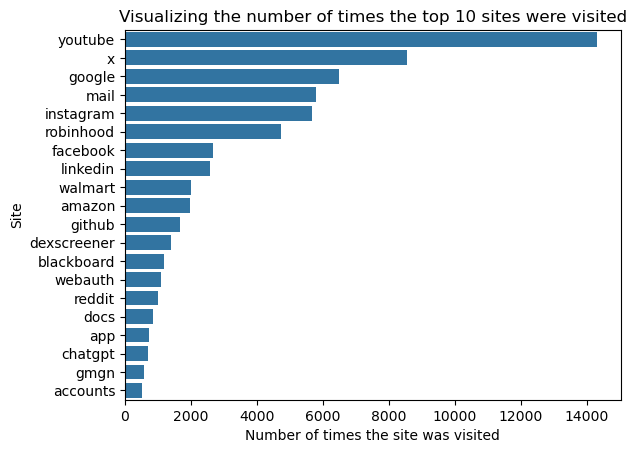

In [17]:
# barplot
sns.barplot(x = most_visited_sites_based_on_count_top20["count"], y = most_visited_sites_based_on_count_top20["domain"])
plt.xlabel("Number of times the site was visited")
plt.ylabel("Site")
plt.title("Visualizing the number of times the top 10 sites were visited")

Well, I love youtube and Twitter (X). I also am very active in trading. So, thats probably why robinhood, dexscreener and gmgn are amongst the top 15 most visited sites.

In [18]:
df["Month"].value_counts() # number of visits based on month

Month
1     38514
12    28699
2      9993
Name: count, dtype: int64

Since I had cleared my browsing history just 2 months ago, visualizing based on months is probably not going to be useful as I only have 3 months worth of data.

In [19]:
df["Hour"].value_counts() # number of total visits based on hour

Hour
18    8479
19    8053
2     6968
17    6728
20    6585
3     5948
1     5515
0     5098
21    4834
22    4087
4     4028
23    3959
16    3860
15    1362
5      830
6      430
14     291
7      109
13      42
Name: count, dtype: int64

Let's look at hourly variations

In [20]:
# get number of visits based onhour
number_of_visits_based_on_hour = df.groupby("Hour")["date"].count().reset_index()
number_of_visits_based_on_hour.rename(columns = {"date": "count"}, inplace=True)
number_of_visits_based_on_hour

,Hour,count
0,0,5098
1,1,5515
2,2,6968
3,3,5948
4,4,4028
5,5,830
6,6,430
7,7,109
8,13,42
9,14,291


Text(0.5, 1.0, 'Number of visits based on hour')

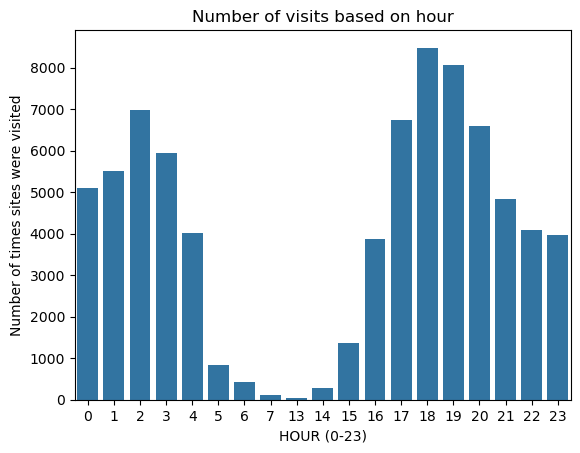

In [21]:
sns.barplot(x="Hour", y = "count", data=number_of_visits_based_on_hour)
plt.xlabel("HOUR (0-23)")
plt.ylabel("Number of times sites were visited")
plt.title("Number of visits based on hour")

I am pretty active in the late and early morning watching youtube and trading. That could be the reason there are larger bars in the early morning and late evening. However, the afternoons have very low visits. Most of my work related meetings happen in that time. That could be the reason as I won't be watching stuff then.

<b> Let's see the same thing but during weekdays and weekends

In [22]:
# only select rows for weekend
weekend_df = df[df.Day.isin(["Saturday", "Sunday"])]

# only select rows for weekdays
weekday_df = df[~df.Day.isin(["Saturday", "Sunday"])]

In [23]:
weekend_df.Day.unique().shape, weekday_df.Day.unique().shape

((2,), (5,))

In [24]:
# get number of visits with respect to hour for weekend days
weekend_df = weekend_df.groupby("Hour")["date"].count().reset_index()
weekend_df.rename(columns = {"date": "count"}, inplace=True)

# get number of visits with respect to hour for weekdays
weekday_df = weekday_df.groupby("Hour")["date"].count().reset_index()
weekday_df.rename(columns = {"date": "count"}, inplace=True)

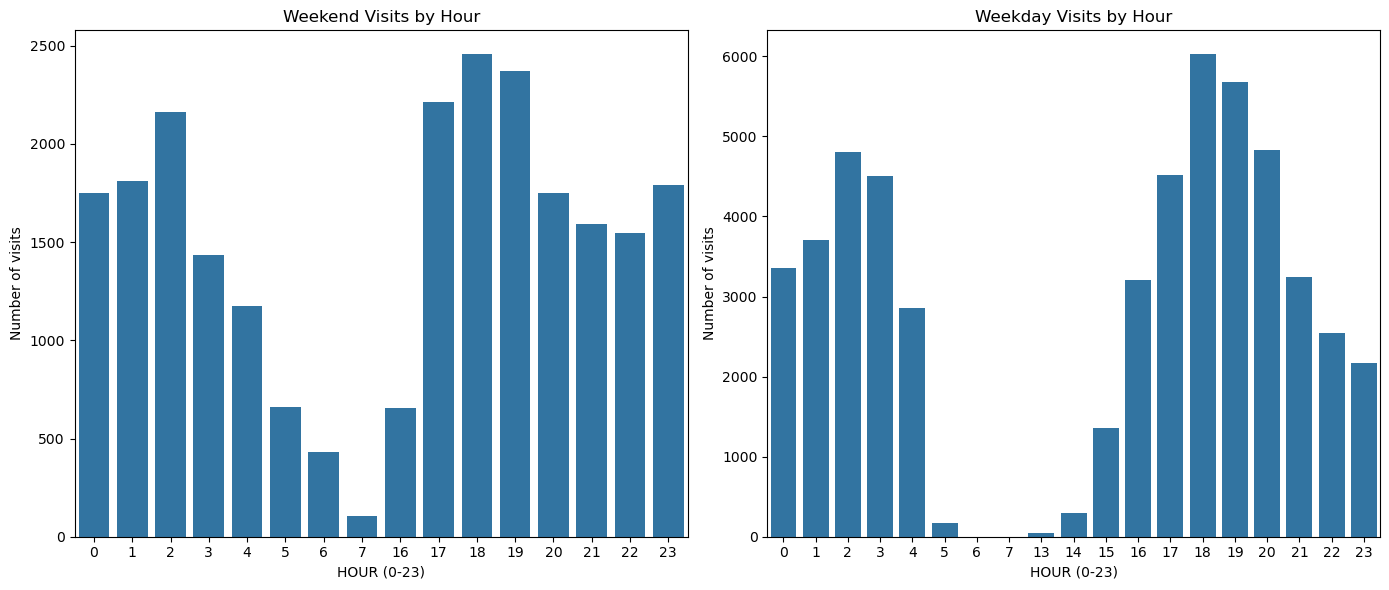

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for weekends
sns.barplot(x="Hour", y="count", data=weekend_df, ax=axes[0])
axes[0].set_xlabel("HOUR (0-23)")
axes[0].set_ylabel("Number of visits")
axes[0].set_title("Weekend Visits by Hour")

# Plot for weekdays
sns.barplot(x="Hour", y="count", data=weekday_df, ax=axes[1])
axes[1].set_xlabel("HOUR (0-23)")
axes[1].set_ylabel("Number of visits")
axes[1].set_title("Weekday Visits by Hour")

plt.tight_layout()
plt.show()


We can see that the pattern on both weekdays and weekends is very similar. My work is fully remote and very flexible. So, my schedule and timing being in front of the laptop screen is pretty consistent across all days. 

In [26]:
# get number of visits with respect to the day
visits_by_days = df.groupby("Day")["date"].count().reset_index()
visits_by_days = visits_by_days.rename(columns={"date": "count"})

In [27]:
visits_by_days

,Day,count
0,Friday,9866
1,Monday,12290
2,Saturday,12451
3,Sunday,11456
4,Thursday,11519
5,Tuesday,10398
6,Wednesday,9226


<b> Lets sort the dataframe based on days

In [28]:
# this is the order selected
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# convert the Day column into categorical form and ordering the categories based on the above order, and sorting them
visits_by_days["Day"] = pd.Categorical(visits_by_days["Day"], categories=order, ordered=True)
visits_by_days = visits_by_days.sort_values("Day").reset_index(drop=True)

In [29]:
visits_by_days

,Day,count
0,Monday,12290
1,Tuesday,10398
2,Wednesday,9226
3,Thursday,11519
4,Friday,9866
5,Saturday,12451
6,Sunday,11456


Text(0.5, 1.0, 'Number of visits accross the week')

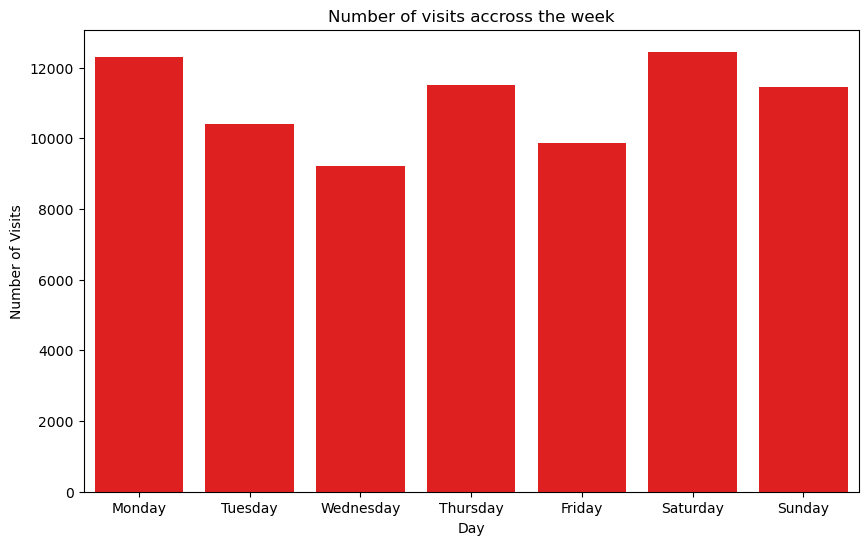

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(x=visits_by_days["Day"], y = visits_by_days["count"], ax=ax, color = 'red')
plt.xlabel("Day")
plt.ylabel("Number of Visits")
plt.title("Number of visits accross the week")

There is no definitive pattern to look for here as it is the same pattern as hourly basis. Since all of my work is remote and flexible, this plot does not show any sort of distinction like you would see for someone's browsing history who does 9-5 in person job.

In [32]:
# lets get  rows only between 9 to 5 
work_hours = df[(df['Hour'] >= 9) & (df['Hour'] <= 17)]

# lets look for the sites that are mostly used during work hours
work_hours = work_hours[work_hours['domain'].isin(['linkedin', 'github', 'mail'])]['domain'].value_counts()

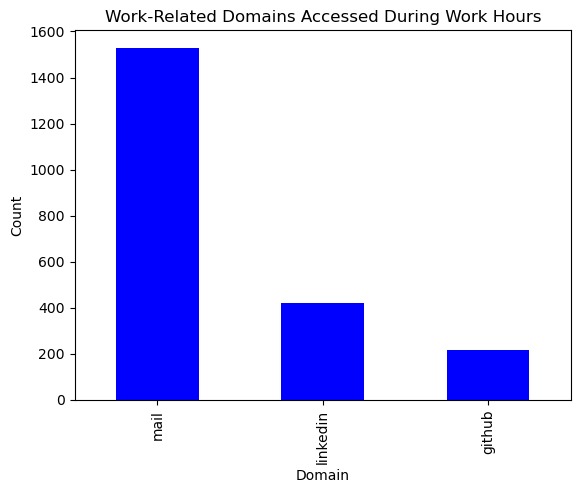

In [33]:
work_hours.plot(kind='bar', color='blue', title='Work-Related Domains Accessed During Work Hours')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.show()

There is a significant activity and lots of visits to work-related sites during work time. 

In [34]:
# lets also sort the dataframe with respect to days
df["Day"] = pd.Categorical(df["Day"], categories=order, ordered=True)
df = df.sort_values("Day").reset_index(drop=True)

In [35]:
pivot_table = df.pivot_table(index='Hour', columns='Day', values='domain', aggfunc='count')

C:\Users\neupa\AppData\Local\Temp\ipykernel_18192\608824773.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index='Hour', columns='Day', values='domain', aggfunc='count')


In [36]:
pivot_table

Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0,1001,597,630,651,471,989,759
1,1031,1190,667,393,424,901,909
2,1336,1031,975,714,747,1374,791
3,843,900,851,1263,654,763,674
4,513,404,406,613,917,536,639
5,21,51,25,1,69,278,385
6,0,0,1,0,0,227,202
7,0,0,1,0,0,108,0
13,28,0,14,0,0,0,0


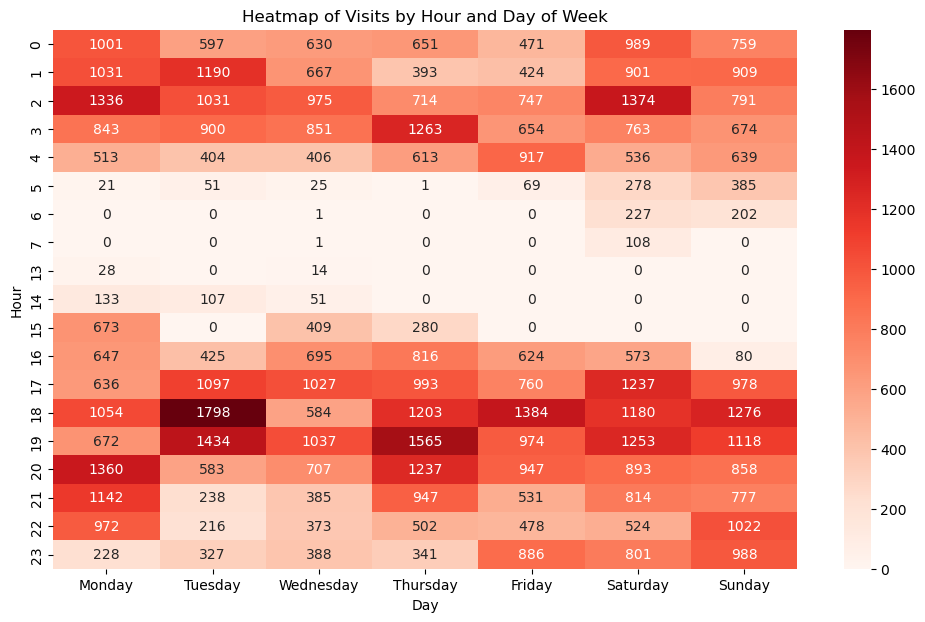

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
sns.heatmap(pivot_table, cmap='Reds', annot=True, fmt='.0f', ax=ax)
plt.title('Heatmap of Visits by Hour and Day of Week')
plt.xlabel('Day')
plt.ylabel('Hour')
plt.show()

The 0 values here are essentially NAN values being replaced while ordering based on days. The heatmap also aligns with the hourly count plot for weekdays and weekends. There are similar and low visits during 5-16 hours timeframe. It could be due to being focused on work stuff. The user has consistent traffics in the late evening and early morning throughout all days.

In [228]:
import plotly.express as px
import plotly.graph_objects as go

In [40]:
# get the number of visits per hour per date
df_hour = df.set_index('date').resample('H').size().reset_index()
df_hour.rename(columns={0: "count"}, inplace=True)
df_hour

C:\Users\neupa\AppData\Local\Temp\ipykernel_18192\39320316.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df.set_index('date').resample('H').size().reset_index()


,date,count
0,2024-12-07 02:00:00,296
1,2024-12-07 03:00:00,274
2,2024-12-07 04:00:00,60
3,2024-12-07 05:00:00,0
4,2024-12-07 06:00:00,0
...,...,...
1486,2025-02-07 00:00:00,0
1487,2025-02-07 01:00:00,96
1488,2025-02-07 02:00:00,2
1489,2025-02-07 03:00:00,96


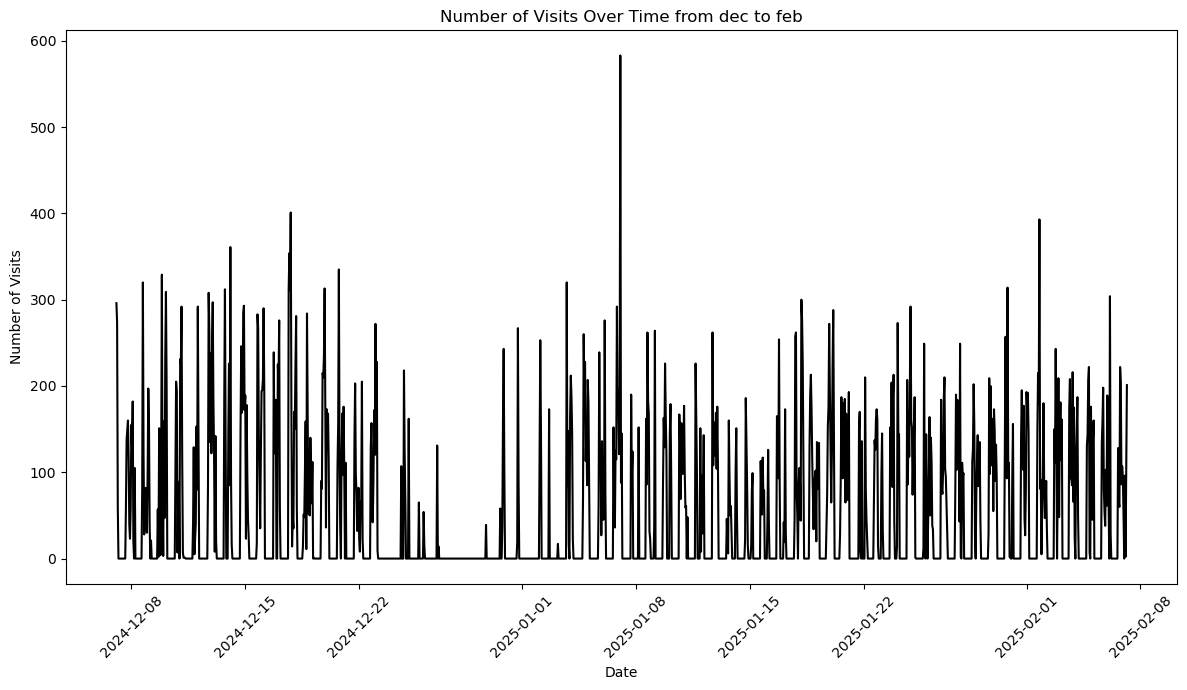

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
sns.lineplot(data=df_hour, x='date', y='count', ax=ax, color='black')
plt.title('Number of Visits Over Time from dec to feb')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

If we look here, there is a lot of gaps between dec 23 and  jan 2. It makes sense as I was out in Texas at my friends place. So, I did not use my computer much then. 

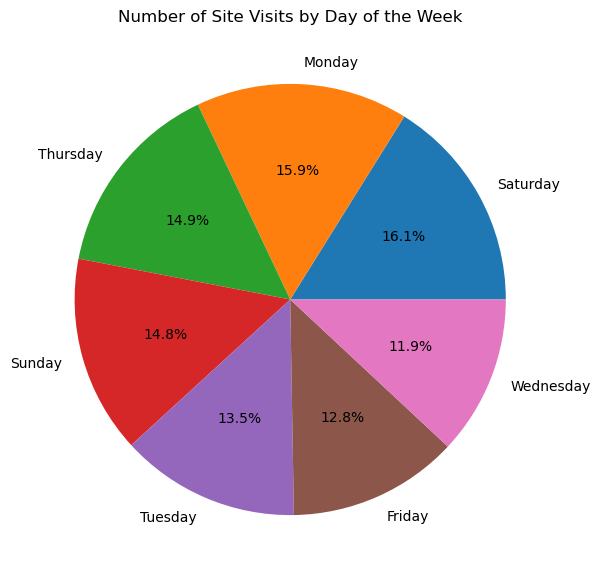

In [50]:
day_counts = df['Day'].value_counts().reset_index()
day_counts.columns = ['Day', 'count']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.pie(day_counts['count'], labels=day_counts['Day'], autopct='%1.1f%%')
plt.title('Number of Site Visits by Day of the Week')
plt.show()

There is no definitive pattern to look for here as it is the same pattern as hourly basis. Since all of my work is remote and flexible, this plot does not show any sort of distinction like you would see for someone's browsing history who does 9-5 in person job.

In [52]:
# get rows for top 20 most visited domains only
most_visited_domains_df = df[df.domain.isin(most_visited_sites_based_on_count_top20.domain.values)]
most_visited_domains_df

,date,domain,Year,Month,Day,Hour
0,2025-01-06 02:04:40.325533,github,2025,1,Monday,2
1,2025-01-27 20:23:10.384400,youtube,2025,1,Monday,20
2,2025-01-27 20:23:10.339428,youtube,2025,1,Monday,20
3,2025-01-27 20:23:10.272100,youtube,2025,1,Monday,20
4,2025-01-27 20:23:03.744091,youtube,2025,1,Monday,20
...,...,...,...,...,...,...
77201,2025-01-05 00:54:14.762737,robinhood,2025,1,Sunday,0
77202,2025-01-05 00:54:12.634175,robinhood,2025,1,Sunday,0
77203,2025-01-05 00:54:12.220973,robinhood,2025,1,Sunday,0
77204,2025-01-05 01:00:28.446789,google,2025,1,Sunday,1


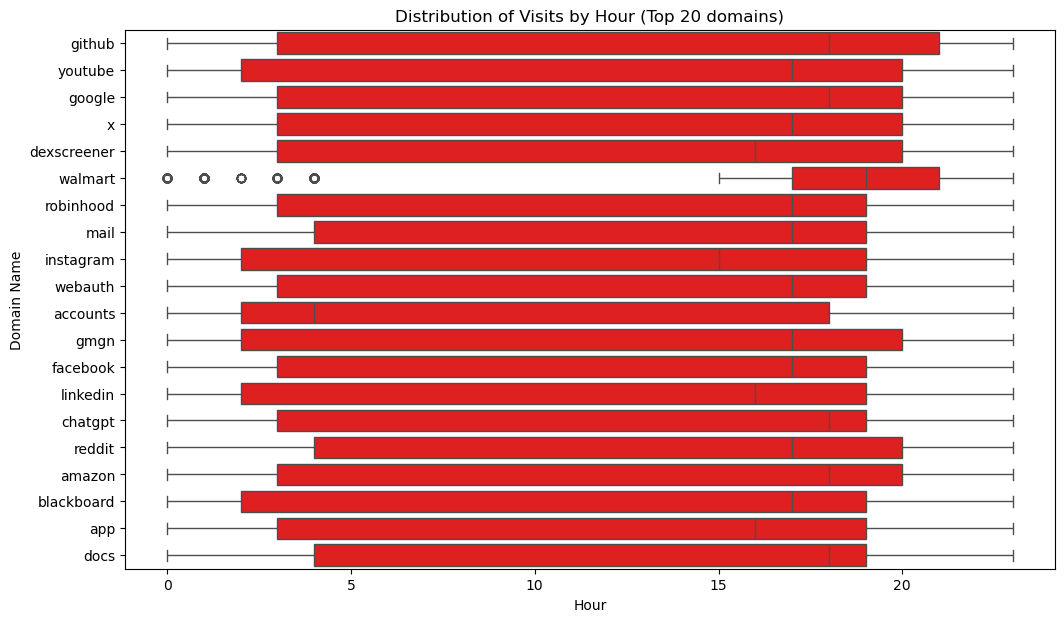

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
sns.boxplot(x='Hour', y='domain', data=most_visited_domains_df, ax=ax, color='red')
plt.title('Distribution of Visits by Hour (Top 20 domains)')
plt.xlabel('Hour')
plt.ylabel('Domain Name')
plt.show()

If we look at the distribution of entertainment sites like Youtube, X etc, it shows a very wide distribution indicating that those sites have been visited all the time. Furthermore, walmart has been visited at very specific hours. It makes sense as I usually set up my walmart delivery in late afternoon and evening. Also, other domains are also visited frequently, indicating the user is staying in front of his laptop screen, which is true.

# Conclusion (Final Analysis)

## 1. Is this a work computer or personal computer?
The dataset shows that the individual is doing both personal and work related stuff in the computer. There is a high volume visits to sites like LinkedIn, and Github, indicating lots of work related stuff might be happening. Similarly, there is also a very high volumne visits to Youtube, Robinhood, Instagram, Faceboook etc indicating personal usage. So, This computer could be used for both personal and work related stuff.


## 2. Is the user employed?
The individual seems to be using sites like LinkedIn, mail, and github a lot, especially during work hours. Therefore, it is likely that the individual is employeed. Futthremore, the usage of these sites also pretty much consistent during weekends and weekdays, and other hours, indicating that the individual's job could be very flexible and remote.

## 3. What are the person's interests?
This person absolutely loves trading. Lots of visits to Robinhood, and dexscreener (which is a decentralzed trading platform for crypto). So, this person may be interested in investing in crypto. The person also has lots of visits to amazon and walmart, indicating that they might be actively shopping. 


This individual is very active during late evenings and morning, indicating that they may have a night (but online) lifestyle. Perhaps, they do active crypto trading in the late nights. There don't seem to be any indication of interest towards video games based on the browsing history. 